In [1]:
sys.path.insert(0, '../../Libraries')
from ltar import LTAR
import numpy as np
import pandas as pd
import numpy.random as random
import scipy.fft as sfft
import pywt
import JacksonsTSPackage as jts
from statsmodels.tsa.api import VAR

In [2]:
def mul_ten_and_mat(tensor, matrix):
    
    matrix_shape = matrix.shape
    ten_length = len(tensor)
    ten_sqr = ten_length*ten_length
    block_matrix = np.zeros((ten_sqr, ten_sqr))

    # Makes the block vector
    trans_vector = sfft.dct(matrix, axis=1)
    block_vector = trans_vector.transpose().reshape(ten_sqr)

    # Makes the block matrix
    transform_tensor = sfft.dct(tensor, axis=0)
    for i in range(ten_length):
        c = i * 3
        block_matrix[c:c+3,c:c+3] = transform_tensor[i]

    result_block_vector = np.matmul(block_matrix, block_vector)
    result_trans_matrix = result_block_vector.reshape(matrix_shape).transpose()
    result_matrix = sfft.idct(result_trans_matrix, axis=1)

    return result_matrix

N = 2000

A = np.array([
    [
        [0.4, 0, 0],
        [0, 0.4, 0],
        [0, 0, 0.4]
    ],
    [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]
    ],
    [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]
    ]
    ])

c = np.array(
    [[0.8, 0, 0],
    [0, 0, 0.8],
    [0, 0.8, 0]])

#A = np.random.uniform(-0.3, 0.3, size=(3, 3, 3))

tmp = np.array(
    [
        [0.1, 0.2, 0.3],
        [0.4, 0.5, 0.6],
        [0.7, 0.8, 0.9]
    ])

data_tensor = np.zeros((N, 3, 3))
data_tensor[0] = tmp
for i in range(1, N):
    data_tensor[i] = c + mul_ten_and_mat(A, data_tensor[i-1]) + random.uniform(-1, 1, (3, 3))
data_tensor.shape

(2000, 3, 3)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

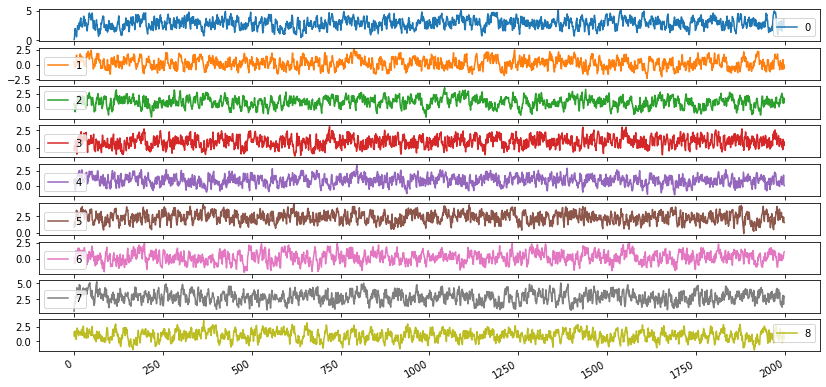

In [3]:
vectorized = pd.DataFrame(jts.tensor_to_vector(data_tensor))
vectorized.plot(figsize = (14, 7), subplots = True)

In [4]:
N_train = 1800
N_test = N - N_train
print(f"N: {N}")
print(f"N_train: {N_train}")
print(f"N_test: {N_test}")

N: 2000
N_train: 1800
N_test: 200


In [5]:
train_tensor = jts.extract_train_tensor(data_tensor, N_train)
test_tensor = jts.extract_test_tensor(data_tensor, N_train, N_test)

In [6]:
p = 1
ltar = LTAR(train_tensor)
ltar.fit(p)

In [7]:
forcast_tensor = ltar.forecast(N_test)
forcast_tensor

array([[[ 3.95580971,  0.53875736, -0.42147357],
        [ 0.04811561,  0.1339247 ,  1.95327804],
        [ 1.11895766,  2.3057807 ,  1.17900248]],

       [[ 3.59124566,  0.75545198, -0.29418509],
        [ 0.0275393 ,  0.34661904,  2.13347962],
        [ 1.07304707,  2.34697535,  1.09980284]],

       [[ 3.36610777,  0.83648452, -0.16637194],
        [ 0.03546431,  0.4865465 ,  2.2840206 ],
        [ 1.04410451,  2.35851021,  1.05262118]],

       ...,

       [[ 2.86932358,  0.86778034,  0.23245381],
        [ 0.2459856 ,  0.9211219 ,  2.84301314],
        [ 0.95522124,  2.31754737,  0.97349318]],

       [[ 2.86932358,  0.86778034,  0.23245381],
        [ 0.2459856 ,  0.9211219 ,  2.84301314],
        [ 0.95522124,  2.31754737,  0.97349318]],

       [[ 2.86932358,  0.86778034,  0.23245381],
        [ 0.2459856 ,  0.9211219 ,  2.84301314],
        [ 0.95522124,  2.31754737,  0.97349318]]])

In [8]:
ltar.coefs[0]

array([[[ 4.01305857e-01,  8.67338623e-03, -6.83441025e-03],
        [ 4.83247493e-03,  4.01670274e-01,  1.81241932e-03],
        [ 6.13393520e-03, -6.08217165e-03,  4.20186412e-01]],

       [[-6.94381558e-04,  8.01499763e-05,  8.04902260e-03],
        [-2.87793939e-03, -1.57996934e-03, -9.08489839e-03],
        [-6.79272716e-03,  8.11222324e-03, -1.92111869e-02]],

       [[-5.30665740e-03, -1.05029309e-02, -8.85294249e-03],
        [ 1.43837706e-03,  7.02136737e-04,  6.75205167e-03],
        [-3.83595216e-03,  4.69901460e-04, -3.93372850e-03]]])

In [9]:
ltar.c

array([[ 0.85971215,  0.05677677, -0.00640251],
       [-0.01396509, -0.0079753 ,  0.79509196],
       [ 0.0116871 ,  0.78678115,  0.09154333]])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

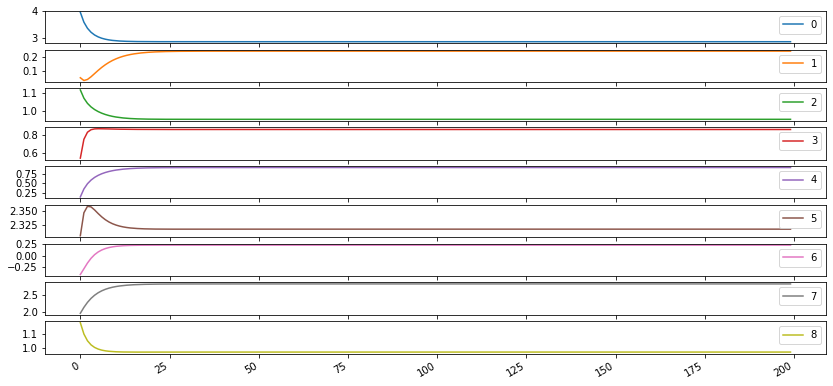

In [10]:
result_vectorized = pd.DataFrame(jts.tensor_to_vector(forcast_tensor))
result_vectorized.plot(figsize = (14, 7), subplots = True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

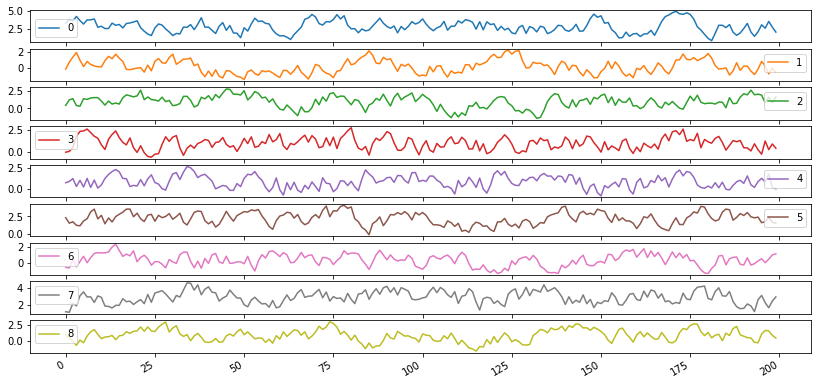

In [11]:
test_vectorized = pd.DataFrame(jts.tensor_to_vector(test_tensor))
test_vectorized.plot(figsize = (14, 7), subplots = True)

In [12]:
error = jts.calc_mape_per_matrix(test_tensor, forcast_tensor)
error = error.rename(columns={"MAPE": "DCT"})
error

,DCT
0,0.333126
1,0.403354
2,0.418354
3,0.584342
4,0.448538
...,...
195,0.333137
196,0.255394
197,0.393366
198,0.305417


<AxesSubplot:>

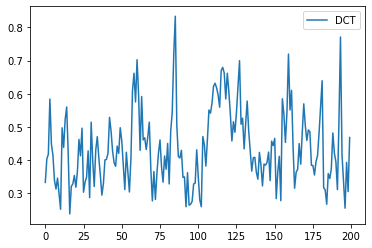

In [13]:
error.plot()

In [14]:
jts.forecast_accuracy(result_vectorized, test_vectorized)

Results
----------------------------------------------------------------------
           ME            MSE            MAE            MAPE
0       0.026          0.676          0.663          27.371%       
1       0.061          0.735          0.711          172.487%      
2       0.032          0.721          0.686          218.805%      
3       -0.104         0.489          0.579          337.385%      
4       0.052          0.519          0.600          455.378%      
5       0.109          0.783          0.732          64.256%       
6       -0.149         0.570          0.628          133.042%      
7       -0.093         0.510          0.593          22.182%       
8       0.154          0.862          0.751          305.292%      
